In [1]:
# ------------------------------------------------------------------------------ #
# This notebook is adapted from "bayes_analysis.nb" in the same directory.
# It has been modified to analyze a model which includes information about 
# cortical layers.
# This is work in progress, and might contain many notes and questions written to help me understand and explore the methods used here.
# ------------------------------------------------------------------------------ #

%load_ext autoreload
%autoreload 2

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat/")


2025-01-23 20:53:26,785 | INFO     | notebook | <module> | project directory: /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis


In [2]:

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity, connectivity and layers
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
        "layers.csv"
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

len_before = len(df)
df = df.query("tau_R > 0.0")
df = df.query("tau_double > 0.0 & tau_double < 10.0")

# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py
df

2025-01-23 20:53:30,210 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2025-01-23 20:53:30,375 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/functional_connectivity_analysis_metrics.csv


AssertionError: 

In [3]:
df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    )

unit_id                        stimulus    session  \
5264   950913540  natural_movie_one_more_repeats  766640955   
5265   950913832  natural_movie_one_more_repeats  766640955   
5266   950913944  natural_movie_one_more_repeats  766640955   
5267   950913961  natural_movie_one_more_repeats  766640955   
5268   950913984  natural_movie_one_more_repeats  766640955   
...          ...                             ...        ...   
11917  951190510  natural_movie_one_more_repeats  847657808   
11918  951190512  natural_movie_one_more_repeats  847657808   
11920  951190529  natural_movie_one_more_repeats  847657808   
11921  951190594  natural_movie_one_more_repeats  847657808   
11926  951190848  natural_movie_one_more_repeats  847657808   

                    block ecephys_structure_acronym invalid_spiketimes_check  \
5264   merged_3.0_and_8.0                     VISam                  SUCCESS   
5265   merged_3.0_and_8.0                     VISam                  SUCCESS   
5266   merged_3.0_and_8.0                     VISam                  SUCCESS   
5267   merged_3.0_and_8.0                     VISam                  SUCCESS   
5268   merged_3.0_and_8.0                     VISam                  SUCCESS   
...                   ...                       ...                      ...   
11917  merged_3.0_and_8.0                     VISrl                  SUCCESS   
11918  merged_3.0_and_8.0                     VISrl                  SUCCESS   
11920  merged_3.0_and_8.0                     VISrl                  SUCCESS   
11921  merged_3.0_and_8.0                     VISrl                  SUCCESS   
11926  merged_3.0_and_8.0                     VISrl                  SUCCESS   

       recording_length  firing_rate  \
5264        1679.128662     5.992394   
5265        1657.488525     0.949630   
5266        1679.926514    20.808648   
5267        1679.304443     2.747566   
5268        1676.084473     5.225870   
...                 ...          ...   
11917       1679.032227     2.543132   
11918       1679.941406     5.647221   
11920       1678.552979     4.244132   
11921       1664.325195     1.731032   
11926       1671.657227     0.871590   

                                                filepath  num_spikes  ...  \
5264   /project.nst/neuroscience-raw/Allen/visual_cod...       10062  ...   
5265   /project.nst/neuroscience-raw/Allen/visual_cod...        1574  ...   
5266   /project.nst/neuroscience-raw/Allen/visual_cod...       34957  ...   
5267   /project.nst/neuroscience-raw/Allen/visual_cod...        4614  ...   
5268   /project.nst/neuroscience-raw/Allen/visual_cod...        8759  ...   
...                                                  ...         ...  ...   
11917  /project.nst/neuroscience-raw/Allen/visual_cod...        4270  ...   
11918  /project.nst/neuroscience-raw/Allen/visual_cod...        9487  ...   
11920  /project.nst/neuroscience-raw/Allen/visual_cod...        7124  ...   
11921  /project.nst/neuroscience-raw/Allen/visual_cod...        2881  ...   
11926  /project.nst/neuroscience-raw/Allen/visual_cod...        1457  ...   

          tau_R  tau_single  tau_double  \
5264   0.014985    0.444751    0.266734   
5265   0.094575    0.436281    0.372662   
5266   0.027511    0.616284    0.615629   
5267   0.174547    1.079452    0.671559   
5268   0.052850    2.507153    0.249960   
...         ...         ...         ...   
11917  0.133124    1.288640    1.148265   
11918  0.067862    1.043434    0.851385   
11920  0.105858    0.575930    0.575940   
11921  0.062825    2.570876    0.140626   
11926  0.158897    0.125602    0.119210   

                                           tau_R_details  \
5264   {'firing_rate': 5.424833098092464, 'firing_rat...   
5265   {'firing_rate': 0.9490253334861749, 'firing_ra...   
5266   {'firing_rate': 20.71931568577262, 'firing_rat...   
5267   {'firing_rate': 2.7332735863943713, 'firing_ra...   
5268   {'firing_rate': 5.2043899921543355, 'firing_ra...   
...     

            mu_intercept ~ Normal(0, 1)
         sigma_intercept ~ HalfCauchy(0, 1)
                mu_slope ~ Normal(0, 1)
             sigma_slope ~ HalfCauchy(0, 1)
session_intercept_scaled ~ Normal(0, 1)
    session_slope_scaled ~ Normal(0, 1)
                 b_os_rf ~ Normal(0, 1)
                b_log_fr ~ Normal(0, 1)
                 epsilon ~ HalfCauchy(0, 10)
                   alpha ~ Normal(0, 1)
       session_intercept ~ Deterministic(f(session_intercept_scaled, mu_intercept, sigma_intercept))
           session_slope ~ Deterministic(f(session_slope_scaled, mu_slope, sigma_slope))
              likelihood ~ SkewNormal(f(b_log_fr, b_os_rf, session_intercept_scaled, mu_intercept, session_slope_scaled, mu_slope, sigma_intercept, sigma_slope), epsilon, alpha)


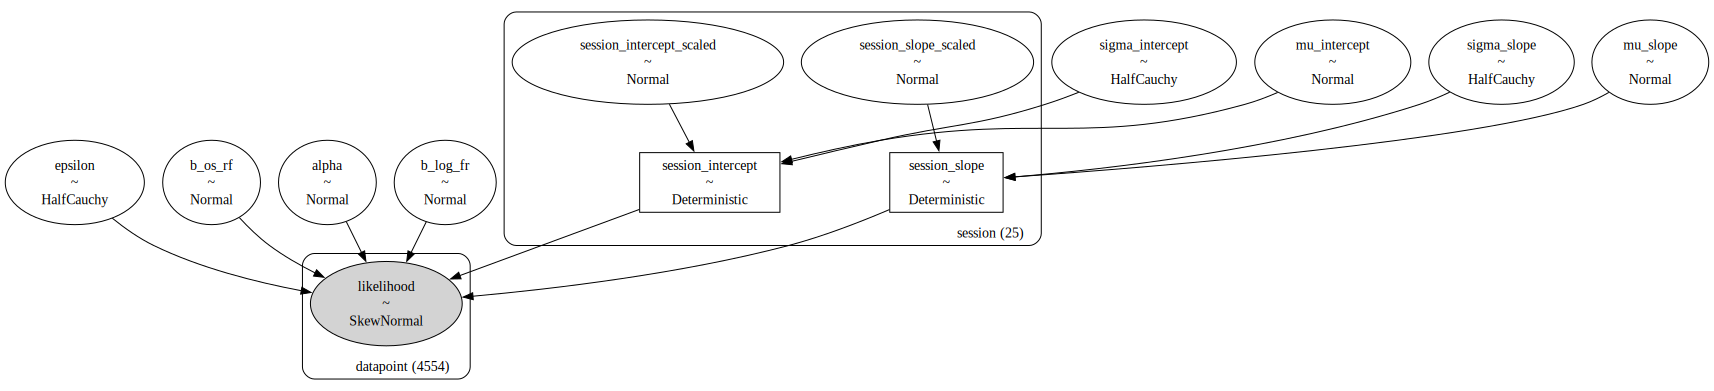

In [3]:
lm_tau_R = bm.LinearMedianModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
print(lm_tau_R.str_repr())
pm.model_to_graphviz(lm_tau_R)

# Example analysis for linear model and measure `R_tot`
### Question: Why isn't it LinearMedianModel instead of StructureGroupModel? and why is the measure "tau_R" instead of "R_tot"?

In [5]:
sgm_tau_R = bm.StructureGroupModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
with sgm_tau_R:
    idata = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [6]:
with sgm_tau_R:
    pm.compute_log_likelihood(idata)
    az.loo(idata, pointwise=True)

Output()

In [7]:
az.loo(idata, pointwise=True)

Computed from 12000 posterior samples and 4554 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -6120.73    65.79
p_loo       38.81        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     4554  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [8]:
with sgm_tau_R:
    idata.extend(pm.sample_prior_predictive(random_seed=42))
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-23 18:07:32,537 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-23 18:07:32,820 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

In [10]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [12]:
az.summary(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_slope",
        "sigma_intercept",
        "sigma_slope",
        "session_slope",
    ],
)

KeyError: 'var names: "[\'mu_slope\' \'sigma_slope\' \'session_slope\'] are not present" in dataset'

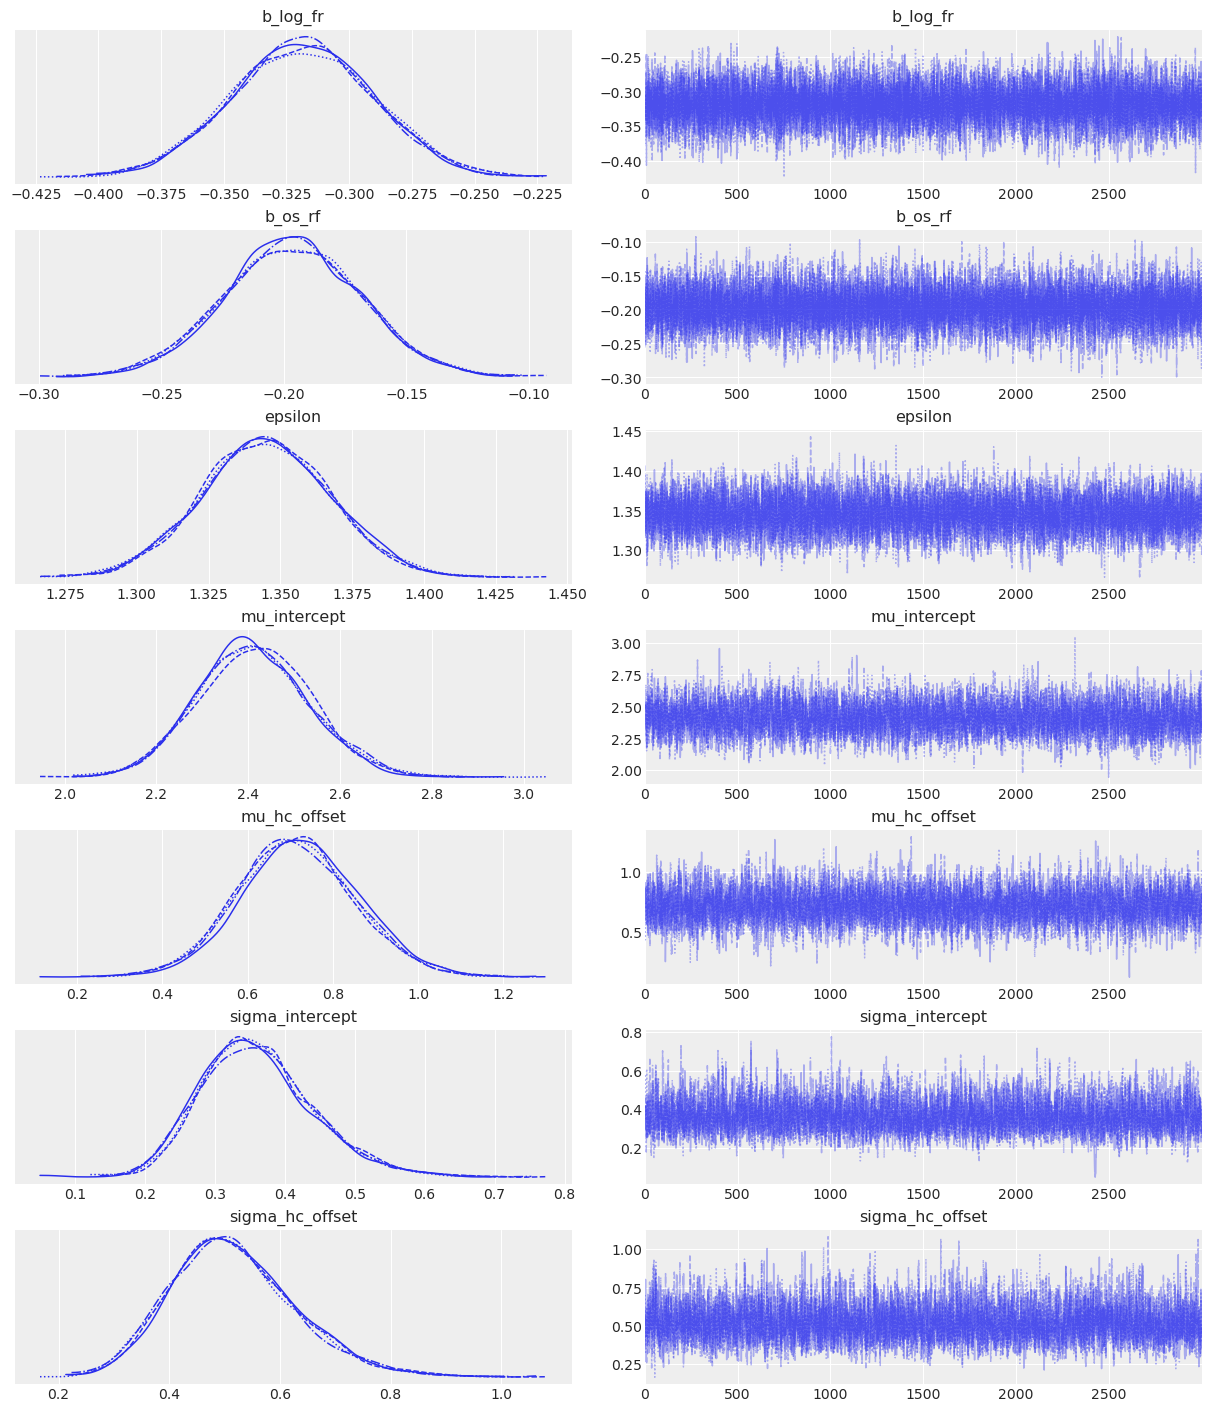

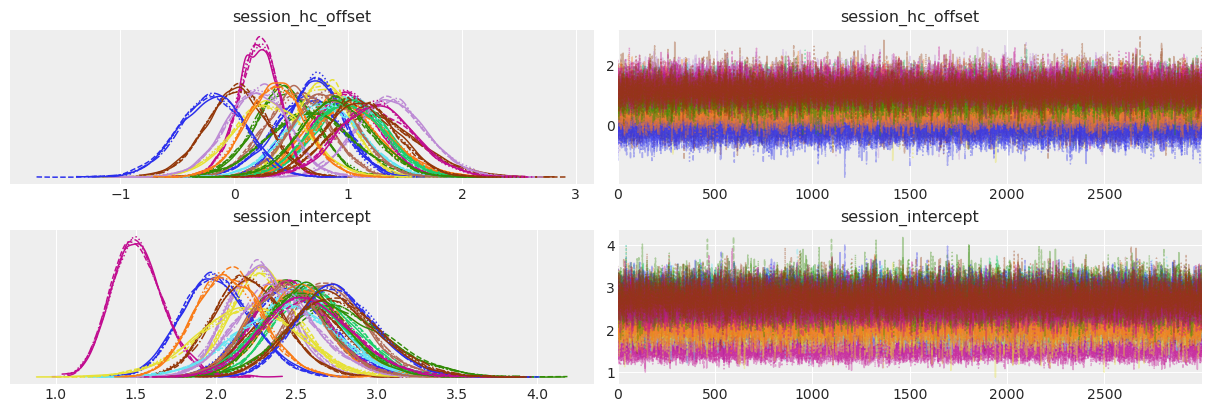

In [13]:
az.style.use("arviz-darkgrid")
# blue lines represent chains
az.plot_trace(
    idata,
    var_names=[
        "b_log_fr",
        "b_os_rf",
        "epsilon",
        "mu_intercept",
        "mu_hc_offset",
        "sigma_intercept",
        "sigma_hc_offset",
    ],
    legend=False,
);
# color varies across sessions
az.plot_trace(
    idata,
    var_names=[
        "session_hc_offset",
        "session_intercept",
    ],
    legend=False,
);

ValueError: setting an array element with a sequence.

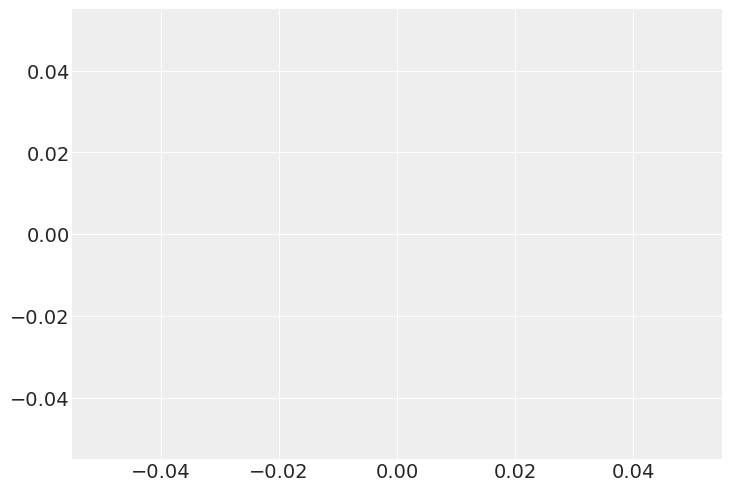

In [14]:
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="prior",
);
az.plot_ppc(
    idata,
    num_pp_samples=100,
    kind="kde",
    group="posterior",
);

# Generate traces for model comparison

In [ ]:
from itertools import product

# define models
models = ["sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
areas = ["cortex"] # only need model for cortex
# areas = ["allareas", "cortex"]
combinations = list(product(areas, models, measures, stimuli))
log.info(f"{combinations=}")

# ~1h on M1 mac
for area, model_name, measure, stim, in combinations:

    if area == "allareas" and model_name == "lmm":
        # linear model needs hierarchy score values, which dont exist for thalamus.
        # for model comparison, we only use models fitted on cortex.
        continue

    log.info(f"running: {model_name} {stim} {measure} {area}")

    if area == "allareas":
        this_df = df
    elif area == "cortex":
        this_df = df.query(f"structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']")
    else:
        raise ValueError(f"unknown area: {area}")

    this_df = this_df.query(f"stimulus == '{stim}'")

    log.info(f"using df for {stim} with {len(this_df)} rows")
    if model_name == "lmm":
        model = bm.LinearMedianModel(
            this_df,
            measure,
            noncentered=True,
        )
    elif model_name == "sgm":
        model = bm.StructureGroupModel(
            this_df,
            measure,
            noncentered=True,
        )
    else:
        raise ValueError(f"unknown model: {model_name}")

    with model:
        idata = pm.sample(
            nuts_sampler="nutpie",
            draws=3000,
            tune=2000,
            random_seed=42,
            target_accept=0.95,
        )

        log.info(f"running ppc: {model_name}")
        idata.extend(pm.sample_prior_predictive(random_seed=42))
        idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=42))

        log.info(f"computing likeliehood: {model_name}")
        idata.extend(pm.compute_log_likelihood(idata))

        log.info(f"saving: {model_name}")
        idata.to_netcdf(
            f"{data_dir}/bayes_{area}_{model_name}_{measure}_{stim}.nc"
        )  # ~ 1.8GB each

2025-01-23 18:16:58,152 | INFO     | notebook | <module> | combinations=[('cortex', 'sgm', 'R_tot', 'natural_movie_three'), ('cortex', 'sgm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'R_tot', 'spontaneous'), ('cortex', 'sgm', 'tau_R', 'natural_movie_three'), ('cortex', 'sgm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_R', 'spontaneous'), ('cortex', 'sgm', 'tau_double', 'natural_movie_three'), ('cortex', 'sgm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_double', 'spontaneous')]
2025-01-23 18:16:58,152 | INFO     | notebook | <module> | running: sgm natural_movie_three R_tot cortex
2025-01-23 18:16:58,161 | INFO     | notebook | <module> | using df for natural_movie_three with 4758 rows


2025-01-23 18:17:20,958 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-23 18:17:21,019 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-23 18:17:21,251 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-23 18:17:23,310 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-23 18:17:25,634 | INFO     | notebook | <module> | saving: sgm
2025-01-23 18:17:47,391 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats R_tot cortex
2025-01-23 18:17:47,398 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 4554 rows


2025-01-23 18:18:07,501 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-23 18:18:07,565 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-23 18:18:07,791 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-23 18:18:09,763 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-23 18:18:11,031 | INFO     | notebook | <module> | saving: sgm
2025-01-23 18:18:31,891 | INFO     | notebook | <module> | running: sgm spontaneous R_tot cortex
2025-01-23 18:18:31,900 | INFO     | notebook | <module> | using df for spontaneous with 4594 rows


2025-01-23 18:18:50,220 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-23 18:18:50,286 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-23 18:18:50,516 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-23 18:18:52,508 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-23 18:18:53,783 | INFO     | notebook | <module> | saving: sgm
2025-01-23 18:19:14,822 | INFO     | notebook | <module> | running: sgm natural_movie_three tau_R cortex
2025-01-23 18:19:14,829 | INFO     | notebook | <module> | using df for natural_movie_three with 4758 rows


2025-01-23 18:20:06,489 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-23 18:20:06,548 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-23 18:20:06,833 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-23 18:20:10,167 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-23 18:20:12,981 | INFO     | notebook | <module> | saving: sgm
2025-01-23 18:20:34,811 | INFO     | notebook | <module> | running: sgm natural_movie_one_more_repeats tau_R cortex
2025-01-23 18:20:34,819 | INFO     | notebook | <module> | using df for natural_movie_one_more_repeats with 4554 rows


2025-01-23 18:21:25,162 | INFO     | notebook | <module> | running ppc: sgm
Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
2025-01-23 18:21:25,218 | INFO     | pymc.sampling.forward | sample_prior_predictive | Sampling: [alpha, b_log_fr, b_os_rf, epsilon, likelihood, mu_hc_offset, mu_intercept, mu_th_offset, session_hc_offset_scaled, session_intercept_scaled, session_th_offset_scaled, sigma_hc_offset, sigma_intercept, sigma_th_offset]
Sampling: [likelihood]
2025-01-23 18:21:25,502 | INFO     | pymc.sampling.forward | sample_posterior_predictive | Sampling: [likelihood]


Output()

2025-01-23 18:21:28,746 | INFO     | notebook | <module> | computing likeliehood: sgm


Output()

2025-01-23 18:21:31,314 | INFO     | notebook | <module> | saving: sgm
2025-01-23 18:21:52,035 | INFO     | notebook | <module> | running: sgm spontaneous tau_R cortex
2025-01-23 18:21:52,044 | INFO     | notebook | <module> | using df for spontaneous with 4594 rows


In [12]:
from itertools import product

# define models

models = ["sgm"]
stimuli = df["stimulus"].unique()
measures = ["R_tot", "tau_R", "tau_double"]
areas = ["cortex"]  # only need model for cortex
# areas = ["allareas", "cortex"]
combinations = list(product(areas, models, measures, stimuli))
log.info(f"{combinations=}")

2024-06-03 08:51:34,788 | INFO     | notebook | <module> | combinations=[('cortex', 'sgm', 'R_tot', 'natural_movie_three'), ('cortex', 'sgm', 'R_tot', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'R_tot', 'spontaneous'), ('cortex', 'sgm', 'tau_R', 'natural_movie_three'), ('cortex', 'sgm', 'tau_R', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_R', 'spontaneous'), ('cortex', 'sgm', 'tau_double', 'natural_movie_three'), ('cortex', 'sgm', 'tau_double', 'natural_movie_one_more_repeats'), ('cortex', 'sgm', 'tau_double', 'spontaneous')]


In [13]:
for area, model_name, measure, stim, in combinations:
    try:
        idata = az.from_netcdf(f"{data_dir}/bayes_{area}_{model_name}_{measure}_{stim}.nc")
    except FileNotFoundError:
        continue

    summary = az.summary(idata)
    r_hat = summary.r_hat
    num_divergences = np.sum(idata.sample_stats.diverging.values)
    print(
        f"{area} {model_name} {measure} {stim}: "
        + f"{'No divergences' if num_divergences == 0 else f'{num_divergences} divergences !!!'} "
        + (f"(r_hat: {r_hat.max():.1f})" if r_hat.max() < 1.1 else f"r_hat: {r_hat.max():.1f} !!!")
    )

cortex sgm R_tot natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm R_tot natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm R_tot spontaneous: No divergences (r_hat: 1.0)
cortex sgm tau_R natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm tau_R natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm tau_R spontaneous: No divergences (r_hat: 1.0)
cortex sgm tau_double natural_movie_three: No divergences (r_hat: 1.0)
cortex sgm tau_double natural_movie_one_more_repeats: No divergences (r_hat: 1.0)
cortex sgm tau_double spontaneous: No divergences (r_hat: 1.0)


# Reviewer Suggestion

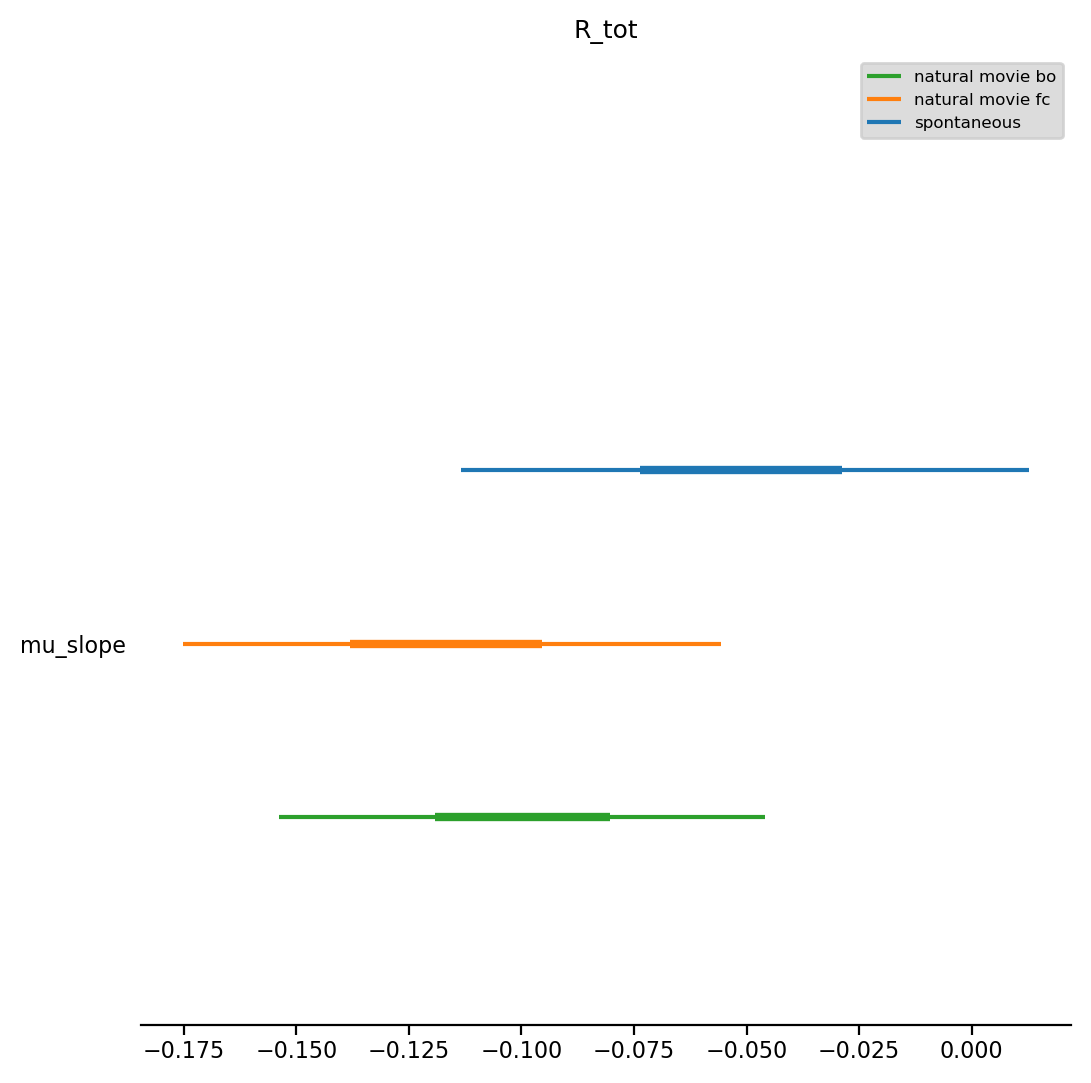

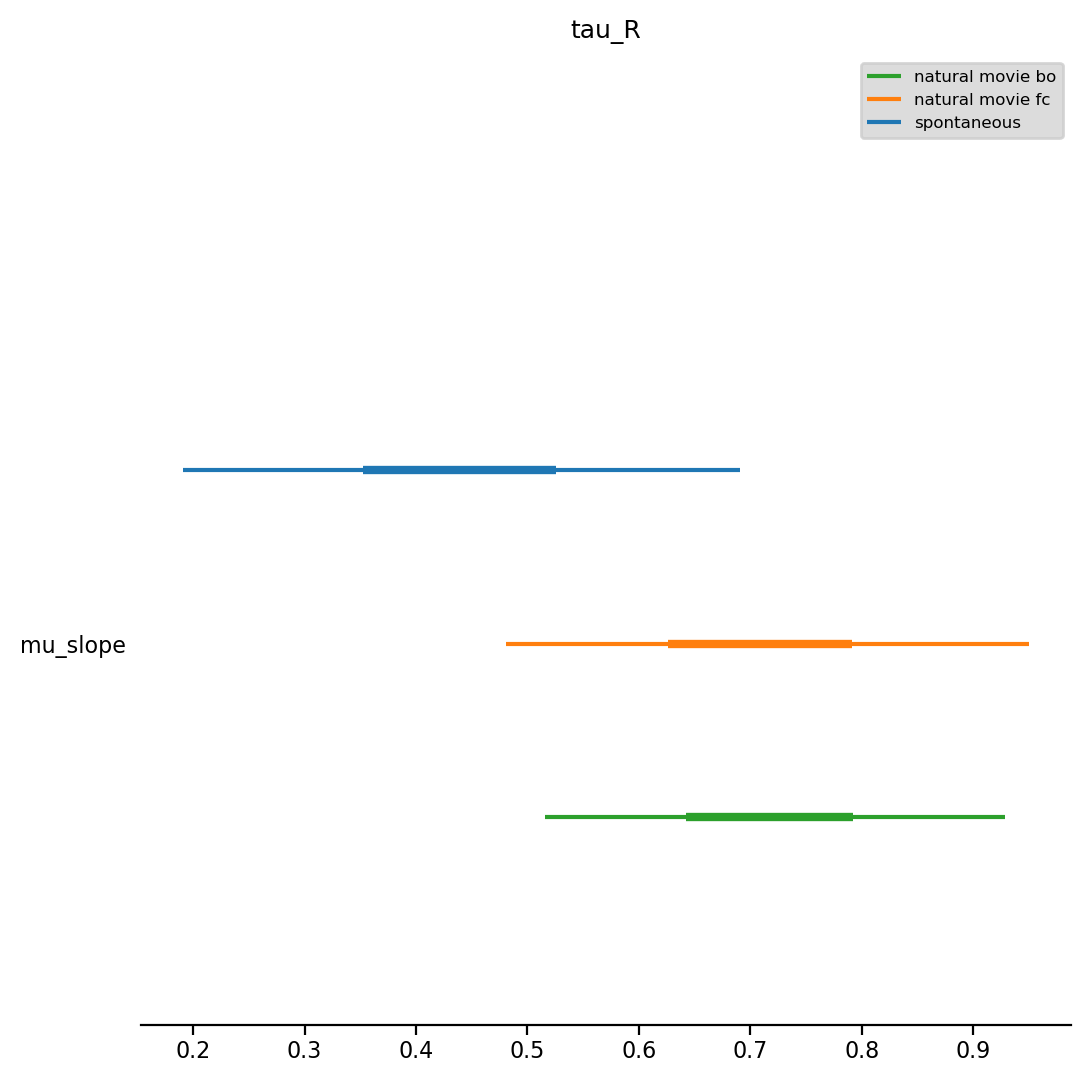

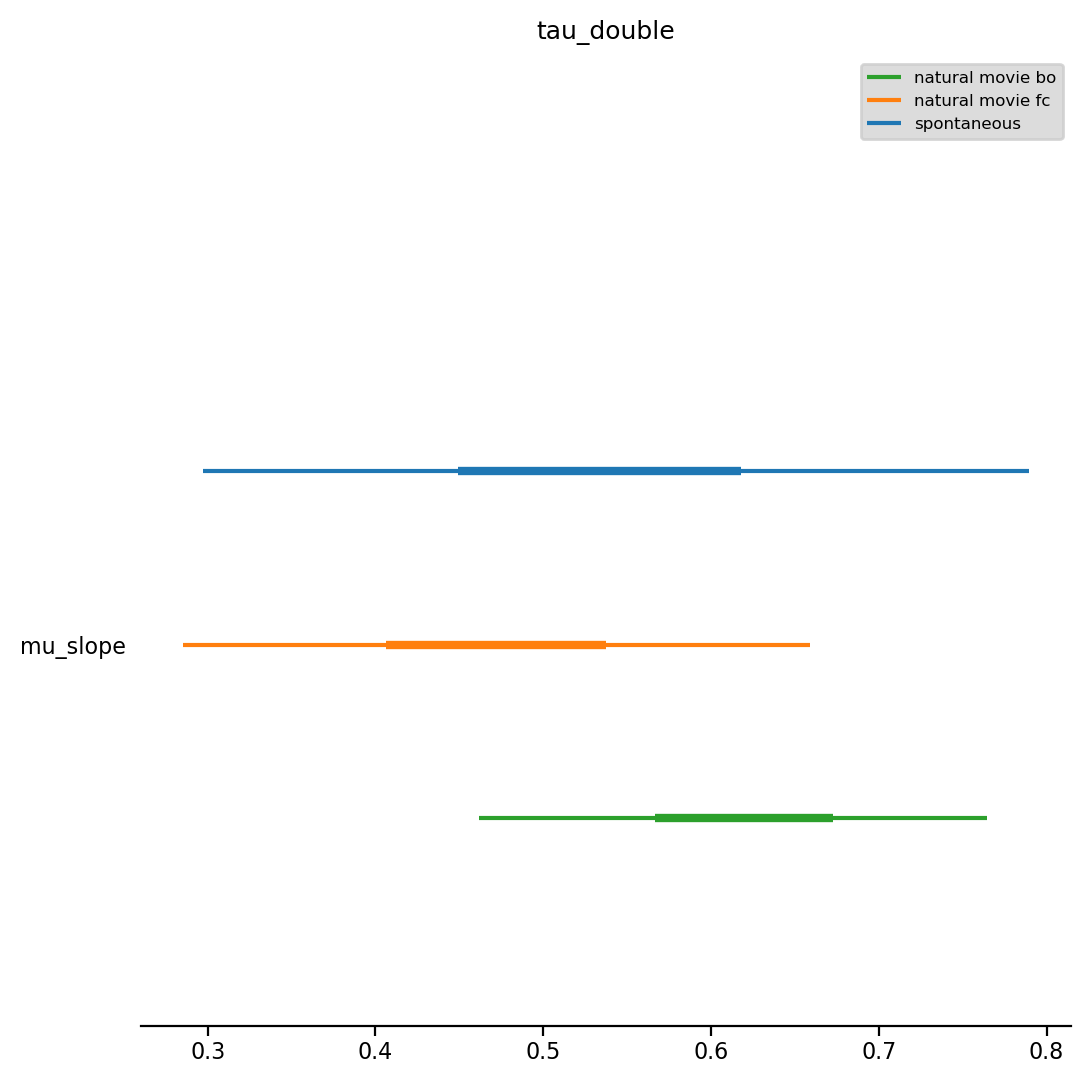

In [26]:
for obs in ["R_tot", "tau_R", "tau_double"]:
    idata_spont = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_spontaneous.nc")
    idata_nat_mov_fc = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_natural_movie_one_more_repeats.nc")
    idata_nat_mov_bo = az.from_netcdf(f"{data_dir}/bayes_cortex_lmm_{obs}_natural_movie_three.nc")
    ax = az.plot_forest(
        [
            idata_spont,
            idata_nat_mov_fc,
            idata_nat_mov_bo,
        ],
        model_names=["spontaneous",  "natural movie fc", "natural movie bo"],
        var_names=["mu_slope"],
        combined=True, # combines chains
        combine_dims=set(["draw", "session"]),
    )
    ax[0].set_title(obs)

In [12]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

nutpie: 0.10.0
pymc  : 5.14.0
arviz : 0.18.0

numpy         : 1.24.4
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
pandas        : 2.0.3
arviz         : 0.18.0
IPython       : 8.22.2
nutpie        : 0.10.0
sqlite3       : 2.6.0
logging       : 0.5.1.2
pymc          : 5.14.0
prompt_toolkit: 3.0.42

